In [105]:
import os,sys
from glob import glob
import xarray as xr
from matplotlib import pyplot as plt
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib
import fiona
import rasterio as rio

# helpers
from xarr_helpers import *


In [106]:
# load the table mountain shapefile
point_file = r"../arc/headwall_neon_poi.shp"
gdf = gpd.read_file(point_file)
print('point CRS: {}'.format(gdf.crs))

gdf_4326 = gdf.to_crs(epsg=4326)
gdf_4326.head()

point CRS: {'init': 'epsg:32613'}


,Id,comments,geometry
0,0,NEON light tarp center,POINT (-105.2449209483192 40.13056064633826)
1,0,NEON dark tarp center,POINT (-105.2450429801881 40.13055609737145)
2,0,some other target?,POINT (-105.2449348460157 40.13027956799884)
3,0,road sample east of tarps,POINT (-105.2445969512152 40.13050721903751)
4,0,4-way intersection,POINT (-105.2445888333624 40.1306683804434)


In [107]:
# NEON data files
data_dirs = !ls -d ../neon_data/*
radiance_files_april09 = glob(data_dirs[0] + '/L1/Spectrometer/RadianceH5/2019040915/*.h5')
radiance_files_april10 = glob(data_dirs[1] + '/L1/Spectrometer/RadianceH5/2019040920/*.h5')

reflectance_files_april09 = glob(data_dirs[0] + '/L1/Spectrometer/ReflectanceH5/2019040915/*.h5')
reflectance_files_april10 = glob(data_dirs[1] + '/L1/Spectrometer/ReflectanceH5/2019040920/*.h5')


# Headwall data files. Currently, only the Surface Reflectance products have been downloaded.
data_dirs_SWIR = !ls -d ../headwall_data/SWIR/*
data_dirs_VNIR = !ls -d ../headwall_data/VNIR/*

# first two directories will be from table mountain. second two are from tennis courts @ CU South
radiance_files_VNIR_april09 = glob(data_dirs_VNIR[0] + '/*.hdr')
radiance_files_VNIR_april09 = [f[:-4] for f in radiance_files_VNIR_april09] # remove the .hdr

radiance_files_SWIR_april09 = glob(data_dirs_SWIR[0] + '/*.hdr')
radiance_files_SWIR_april09 = [f[:-4] for f in radiance_files_SWIR_april09] # remove the .hdr


In [108]:
reflectance_files_april09, radiance_files_VNIR_april09, radiance_files_SWIR_april09

(['../neon_data/2019_R10C_1/L1/Spectrometer/ReflectanceH5/2019040915\\NEON_D10_R10C_DP1_20190409_163351_reflectance.h5',
  '../neon_data/2019_R10C_1/L1/Spectrometer/ReflectanceH5/2019040915\\NEON_D10_R10C_DP1_20190409_163915_reflectance.h5',
  '../neon_data/2019_R10C_1/L1/Spectrometer/ReflectanceH5/2019040915\\NEON_D10_R10C_DP1_20190409_164414_reflectance.h5',
  '../neon_data/2019_R10C_1/L1/Spectrometer/ReflectanceH5/2019040915\\NEON_D10_R10C_DP1_20190409_171839_reflectance.h5',
  '../neon_data/2019_R10C_1/L1/Spectrometer/ReflectanceH5/2019040915\\NEON_D10_R10C_DP1_20190409_172333_reflectance.h5'],
 ['../headwall_data/VNIR/TableMtn_Flight1_processed\\TM_F1_S1',
  '../headwall_data/VNIR/TableMtn_Flight1_processed\\TM_F1_S2',
  '../headwall_data/VNIR/TableMtn_Flight1_processed\\TM_F1_S3',
  '../headwall_data/VNIR/TableMtn_Flight1_processed\\TM_F1_S4',
  '../headwall_data/VNIR/TableMtn_Flight1_processed\\TM_F1_S5'],
 ['../headwall_data/SWIR/TableMtn_Flight1_processed\\TM_F1_S1',
  '../hea

In [109]:
## try to open one of the data files with xarray
neon_ind=4
if neon_ind % 2 == 0:
    fl_dir = 'NS'
else:
    fl_dir = 'EW'
    
hw_ind=1

# these are for the reflectance data
data_file_VNIR = radiance_files_VNIR_april09[hw_ind]
data_file_SWIR = radiance_files_SWIR_april09[hw_ind]
data_file_NEON = reflectance_files_april09[neon_ind] # NEON_D10_R10C_DP1_20190409_172333_reflectance

# but replace with the radiance data
# these are for the reflectance data
data_file_VNIR = '../headwall_data/raw/radiance/VNIR/headwall_TIM_block7296_vnir_rad_glt_cor'
data_file_SWIR = '../headwall_data/raw/radiance/SWIR/headwall_TM_block7443_swir_rad_glt_cor'
data_file_NEON = radiance_files_april09[neon_ind] # NEON_D10_R10C_DP1_20190409_172333_reflectance

neon_id = os.path.basename(data_file_NEON).split('_')[2] # e.g., 'R10C'
print('NEON ID: ', neon_id)
print(data_file_VNIR)

NEON ID:  R10C
../headwall_data/raw/radiance/VNIR/headwall_TIM_block7296_vnir_rad_glt_cor


In [110]:
## read the data into xarray datasets, chunk with Dask
# first Headwall
xarr_VNIR = xr.open_rasterio(data_file_VNIR, chunks=(256, 256, 256))
xarr_SWIR = xr.open_rasterio(data_file_SWIR, chunks=(256, 256, 256))
x_vnir, y_vnir = xarr_VNIR.coords['x'].values, xarr_VNIR.coords['y'].values
x_swir, y_swir = xarr_SWIR.coords['x'].values, xarr_SWIR.coords['y'].values



In [111]:
# in this case, need to extract out the wavelength information!
band_vnir = xr.open_rasterio(radiance_files_VNIR_april09[hw_ind]).coords['band']
band_swir = xr.open_rasterio(radiance_files_SWIR_april09[hw_ind]).coords['band']

xarr_VNIR.coords['band'] = band_vnir
xarr_SWIR.coords['band'] = band_swir

In [112]:
radiance_files_april09
fl_dir = ['NS_N', 'EW_W', 'NS_Both', 'EW', 'NS']
a = {}
for i,fl in enumerate(fl_dir):
    a[fl] = os.path.basename(radiance_files_april09[i])

a


{'NS_N': 'NEON_D10_R10C_DP1_20190409_163351_radiance.h5',
 'EW_W': 'NEON_D10_R10C_DP1_20190409_163915_radiance.h5',
 'NS_Both': 'NEON_D10_R10C_DP1_20190409_164414_radiance.h5',
 'EW': 'NEON_D10_R10C_DP1_20190409_171839_radiance.h5',
 'NS': 'NEON_D10_R10C_DP1_20190409_172333_radiance.h5'}

In [113]:
fl_dir = ['SN-1', 'EW', 'NS', 'WE', 'SN-2']

In [114]:
# then NEON (dask chunking done in-function)
x_neon_ls, y_neon_ls, xarr_NEON_ls = [],[],[]
for dfile in radiance_files_april09:
    x_neon, y_neon, xarr_NEON = NEON_create_rad_xarr_from_h5_file(dfile, nid=neon_id)
    
    x_neon_ls.append(x_neon)
    y_neon_ls.append(y_neon)
    xarr_NEON_ls.append(xarr_NEON)



D:\projects\headwall_neon\notebooks\xarr_helpers.py:44: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  crs_str = f[nid]['Radiance']['Metadata']['Coordinate_System']['Coordinate_System_String'].value
D:\projects\headwall_neon\notebooks\xarr_helpers.py:45: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  crs_epsg = f[nid]['Radiance']['Metadata']['Coordinate_System']['EPSG Code'].value
D:\projects\headwall_neon\notebooks\xarr_helpers.py:46: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  crs_mapinfo = f[nid]['Radiance']['Metadata']['Coordinate_System']['Map_Info'].value
D:\projects\headwall_neon\notebooks\xarr_helpers.py:47: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  crs_proj4 = f[nid]['Radiance']['Metadata']['Coordinate_System']['Proj4'].value
D:\projects\headwall_neon\notebooks\xarr_helpers.py:44: H5pyDeprecationWarning: dataset.val

# Spatial extraction

In [115]:
buffer_dist = 3 # meters

## use the shapefile
pt_index = 0
pt = gdf_4326['geometry'].values[pt_index]
pt_label = gdf_4326['comments'].values[pt_index]
pt_df = gpd.GeoDataFrame({'geometry' : [pt]}, crs=fiona.crs.from_epsg(4326))

# buffer them in the correct coordinate systems
pt_df_hw = pt_df.to_crs(epsg=3857).buffer(buffer_dist, resolution=1).to_crs(epsg=4326)
pt_df_neon = pt_df.to_crs(epsg=32613).buffer(buffer_dist)

In [116]:
## do the extraction
hw_vnir_cube, hw_swir_cube, hw_arrs = extract_from_headwall_ENVI((xarr_VNIR, x_vnir, y_vnir), 
                                                                (xarr_SWIR, x_swir, y_swir), # they are flipped?!
                                                                pt_df_hw,
                                                                w_cutoff = 896) #896 is start of SWIR wavelength

full_wav, full_ex = hw_arrs

# neon flightlines
neon_wav_ls, full_neon_ls = [],[]
for xarr_NEON, x_neon, y_neon in zip(xarr_NEON_ls, x_neon_ls, y_neon_ls):
    neon_sub_cube, neon_arrs = extract_from_NEON((xarr_NEON, x_neon, y_neon), pt_df_neon)
    neon_wav, full_neon = neon_arrs
    
    neon_wav_ls.append(neon_wav)
    full_neon_ls.append(full_neon)

(41, 54, 270) (41, 53, 270)


D:\projects\headwall_neon\notebooks\xarr_helpers.py:245: UserWarning: extracted shapes are not equal, shaving some off...
  warnings.warn('extracted shapes are not equal, shaving some off...')


# plot mean of both systems

In [117]:
hw_mean = np.nanmean(full_ex, axis=1)
hw_max = np.nanmax(full_ex, axis=1)
hw_min = np.nanmin(full_ex, axis=1)

neon_mean_ls, neon_max_ls, neon_min_ls = [],[],[]
for full_neon in full_neon_ls:
    neon_mean = np.nanmean(full_neon, axis=1)
    neon_max = np.nanmax(full_neon, axis=1)
    neon_min = np.nanmin(full_neon, axis=1)
    
    neon_mean_ls.append(neon_mean)
    neon_max_ls.append(neon_max)
    neon_min_ls.append(neon_min)


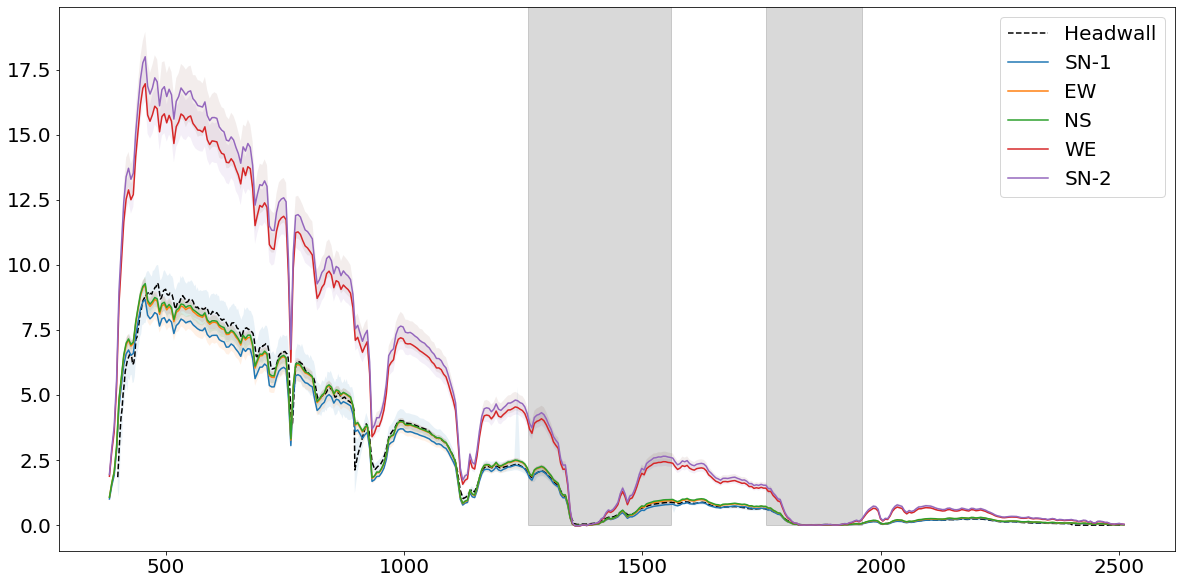

In [118]:
plt.figure(figsize=(20,10))
plt.plot(full_wav, hw_mean, '--k', label='Headwall')
plt.fill_between(full_wav, hw_min, hw_max, alpha=0.1)

for neon_wav, neon_mean, neon_min, neon_max, fl in zip(neon_wav_ls, neon_mean_ls, neon_min_ls, neon_max_ls, fl_dir):
    plt.plot(neon_wav, neon_mean, label=fl)
    plt.fill_between(neon_wav, neon_min, neon_max, alpha=0.1)

# 1260 to 1560 nm (Bands 98-128)
# 1760 to 1960 nm (Bands 148-170)
plt.gca().add_patch(
    plt.Rectangle((1260,0), 1560-1260, 20,color='k', alpha=0.15))

plt.gca().add_patch(
    plt.Rectangle((1760,0), 1960-1760, 20,color='k', alpha=0.15))

plt.legend()                             
plt.show()

In [119]:
# ## replot masking bad bands:
# # 1260 to 1560 nm (Bands 98-128)
# # 1760 to 1960 nm (Bands 148-170)
# bad_neon = np.where(((neon_wav > 1260) & (neon_wav < 1560)) | ((neon_wav > 1760) & (neon_wav < 1960)))
# bad_hw = np.where(((full_wav > 1260) & (full_wav < 1560)) | ((full_wav > 1760) & (full_wav < 1960)))

In [120]:
# hw_mean_ma = hw_mean.copy()
# hw_mean_ma[bad_hw] = np.nan
# hw_max_ma = hw_max.copy()
# hw_max_ma[bad_hw] = np.nan
# hw_min_ma = hw_min.copy()
# hw_min_ma[bad_hw] = np.nan

# neon_mean_ma = neon_mean.copy()
# neon_mean_ma[bad_neon] = np.nan
# neon_max_ma = neon_max.copy()
# neon_max_ma[bad_neon] = np.nan
# neon_min_ma = neon_min.copy()
# neon_min_ma[bad_neon] = np.nan


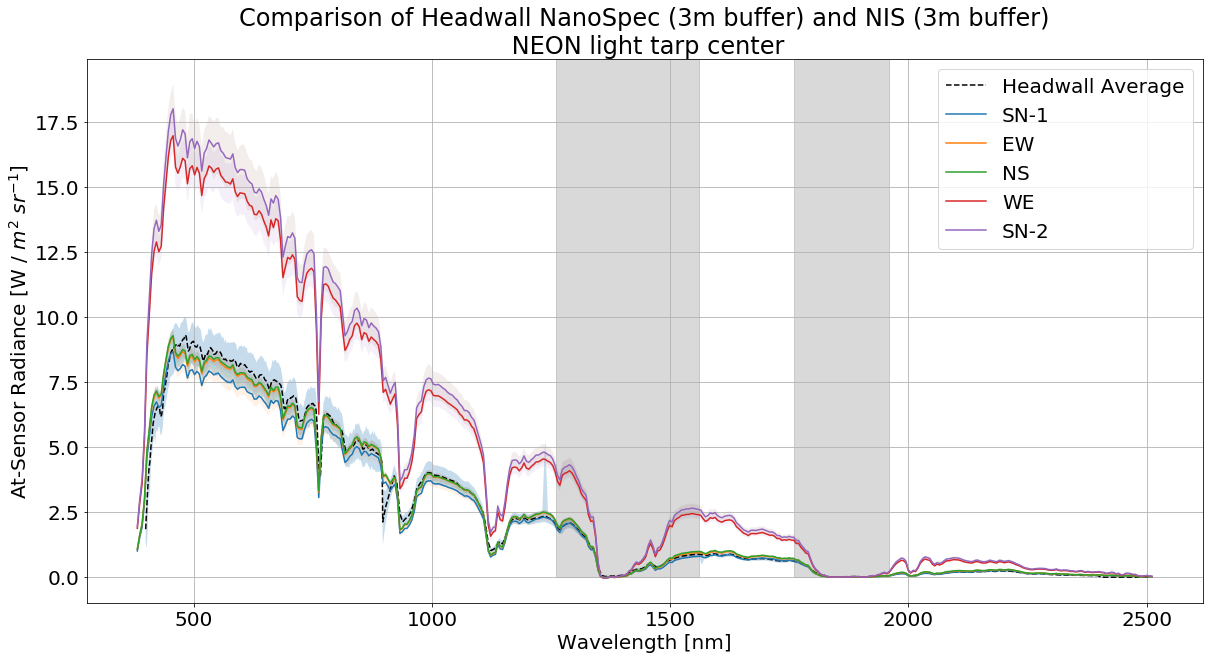

In [121]:
font = {'family' : 'normal',
        'weight' : 'medium',
        'size'   : 20}

matplotlib.rc('font', **font)

plt.figure(figsize=(20,10))
# plt.plot(full_wav, hw_mean_ma, label='Headwall Average')
# plt.fill_between(full_wav, hw_min_ma, hw_max_ma, alpha=0.25)
plt.plot(full_wav, hw_mean, '--k', label='Headwall Average')
plt.fill_between(full_wav, hw_min, hw_max, alpha=0.25)

for neon_wav, neon_mean, neon_min, neon_max, fl in zip(neon_wav_ls, neon_mean_ls, neon_min_ls, neon_max_ls, fl_dir):
    plt.plot(neon_wav, neon_mean, label=fl)
    plt.fill_between(neon_wav, neon_min, neon_max, alpha=0.1)
    
# plt.plot(neon_wav, neon_mean_ma, label='NEON Average')
# plt.fill_between(neon_wav, neon_min_ma, neon_max_ma, alpha=0.25)

# 1260 to 1560 nm (Bands 98-128)
# 1760 to 1960 nm (Bands 148-170)
plt.gca().add_patch(
    plt.Rectangle((1260,0), 1560-1260, 20,color='k', alpha=0.15))

plt.gca().add_patch(
    plt.Rectangle((1760,0), 1960-1760, 20,color='k', alpha=0.15))

plt.title('Comparison of Headwall NanoSpec ({0}m buffer) and NIS ({0}m buffer)\n {1}'.format(buffer_dist, pt_label))
plt.xlabel('Wavelength [nm]')
plt.ylabel('At-Sensor Radiance [W / $m^2$ $sr^{-1}$]')
plt.grid(True)
plt.legend()
plt.show()

In [122]:
bin_res=50
light_tarp_mean, light_tarp_std = bin_data(full_ex, full_wav, full_neon_ls, neon_wav, bin_res)

In [123]:
# plt.figure(figsize=(20,10))
# plt.plot(full_wav, hw_mean_ma, label='Headwall Average')
# plt.fill_between(full_wav, hw_min_ma, hw_max_ma, alpha=0.25)
# plt.plot(neon_wav, neon_mean_ma, label='NEON (ELM) Average')
# plt.fill_between(neon_wav, neon_min_ma, neon_max_ma, alpha=0.25)

# # ASD spectra
# #plt.plot(asd_wav, asd_refl, linewidth=6, alpha=0.5, label='ASD Spectra')

# plt.title('Comparison of Headwall NanoSpec ({0}m buffer) and NIS ({0}m buffer)\n \
#           {1} strip {2}'.format(buffer_dist, fl_dir, pt_label))
# plt.xlabel('Wavelength [nm]')
# plt.ylabel('Reflectance [unitless]')
# plt.grid(True)
# plt.legend()
# plt.show()

# do the same for dark tarp

In [124]:
## use the shapefile
pt_index = 1 # dark tarp
pt = gdf_4326['geometry'].values[pt_index]
pt_label = gdf_4326['comments'].values[pt_index]
pt_df = gpd.GeoDataFrame({'geometry' : [pt]}, crs=fiona.crs.from_epsg(4326))

# buffer them in the correct coordinate systems
pt_df_hw = pt_df.to_crs(epsg=3857).buffer(buffer_dist, resolution=1).to_crs(epsg=4326)
pt_df_neon = pt_df.to_crs(epsg=32613).buffer(buffer_dist)

In [125]:
# ## do the extraction
# neon_sub_cube, neon_arrs = extract_from_NEON((xarr_NEON, x_neon, y_neon), pt_df_neon)
# hw_vnir_cube, hw_swir_cube, hw_arrs = extract_from_headwall_ENVI((xarr_VNIR, x_vnir, y_vnir), 
#                                                             (xarr_SWIR, x_swir, y_swir),
#                                                             pt_df_hw)

# neon_wav, full_neon = neon_arrs
# full_wav, full_ex = hw_arrs

# hw_mean = np.nanmean(full_ex, axis=1)
# hw_max = np.nanmax(full_ex, axis=1)
# hw_min = np.nanmin(full_ex, axis=1)

# neon_mean = np.nanmean(full_neon, axis=1)
# neon_max = np.nanmax(full_neon, axis=1)
# neon_min = np.nanmin(full_neon, axis=1)

# ## replot masking bad bands:
# # 1260 to 1560 nm (Bands 98-128)
# # 1760 to 1960 nm (Bands 148-170)
# bad_neon = np.where(((neon_wav > 1260) & (neon_wav < 1560)) | ((neon_wav > 1760) & (neon_wav < 1960)))
# bad_hw = np.where(((full_wav > 1260) & (full_wav < 1560)) | ((full_wav > 1760) & (full_wav < 1960)))


# hw_mean_ma = hw_mean.copy()
# hw_mean_ma[bad_hw] = np.nan
# hw_max_ma = hw_max.copy()
# hw_max_ma[bad_hw] = np.nan
# hw_min_ma = hw_min.copy()
# hw_min_ma[bad_hw] = np.nan

# neon_mean_ma = neon_mean.copy()
# neon_mean_ma[bad_neon] = np.nan
# neon_max_ma = neon_max.copy()
# neon_max_ma[bad_neon] = np.nan
# neon_min_ma = neon_min.copy()
# neon_min_ma[bad_neon] = np.nan

In [126]:
# asd_spectra1 = "../CUASD/20190409_TBMT_P3C1/0003BlackTarp1/0003BlackTarp1_refl.spectra"
# asd_spectra2 = "../CUASD/20190409_TBMT_P3C1/0003BlackTarp1/0003BlackTarp1_refl.spectra"
# asd1 = pd.read_csv(asd_spectra1, names=['wavelength', 'refl'], header=None, delimiter=r'\t', engine='python')
# asd2 = pd.read_csv(asd_spectra2, names=['wavelength', 'refl'], header=None, delimiter=r'\t', engine='python')

# ## mask the water vapor features
# asd_wav = asd1.wavelength.values
# asd_refl = asd1.refl.values
# bad_asd = np.where(((asd_wav > 1260) & (asd_wav < 1560)) | ((asd_wav > 1760) & (asd_wav < 1960)))
# asd_refl[bad_asd] = np.nan

In [127]:
# plt.figure(figsize=(20,10))
# plt.plot(full_wav, hw_mean_ma, label='Headwall Average')
# plt.fill_between(full_wav, hw_min_ma, hw_max_ma, alpha=0.25)
# plt.plot(neon_wav, neon_mean_ma, label='NEON (ELM) Average')
# plt.fill_between(neon_wav, neon_min_ma, neon_max_ma, alpha=0.25)

# # ASD spectra
# #plt.plot(asd_wav, asd_refl, linewidth=6, alpha=0.5, label='ASD Spectra')

# plt.title('Comparison of Headwall NanoSpec ({0}m buffer) and NIS ({0}m buffer)\n \
#           {1} strip {2}'.format(buffer_dist, fl_dir, pt_label))
# plt.xlabel('Wavelength [nm]')
# plt.ylabel('At-Sensor Radiance [W / $m^2$ $sr^{-1}$]')
# plt.grid(True)
# plt.legend()
# plt.ylim(top=3)
# plt.show()

(41, 53, 270) (42, 53, 270)


D:\projects\headwall_neon\notebooks\xarr_helpers.py:245: UserWarning: extracted shapes are not equal, shaving some off...
  warnings.warn('extracted shapes are not equal, shaving some off...')


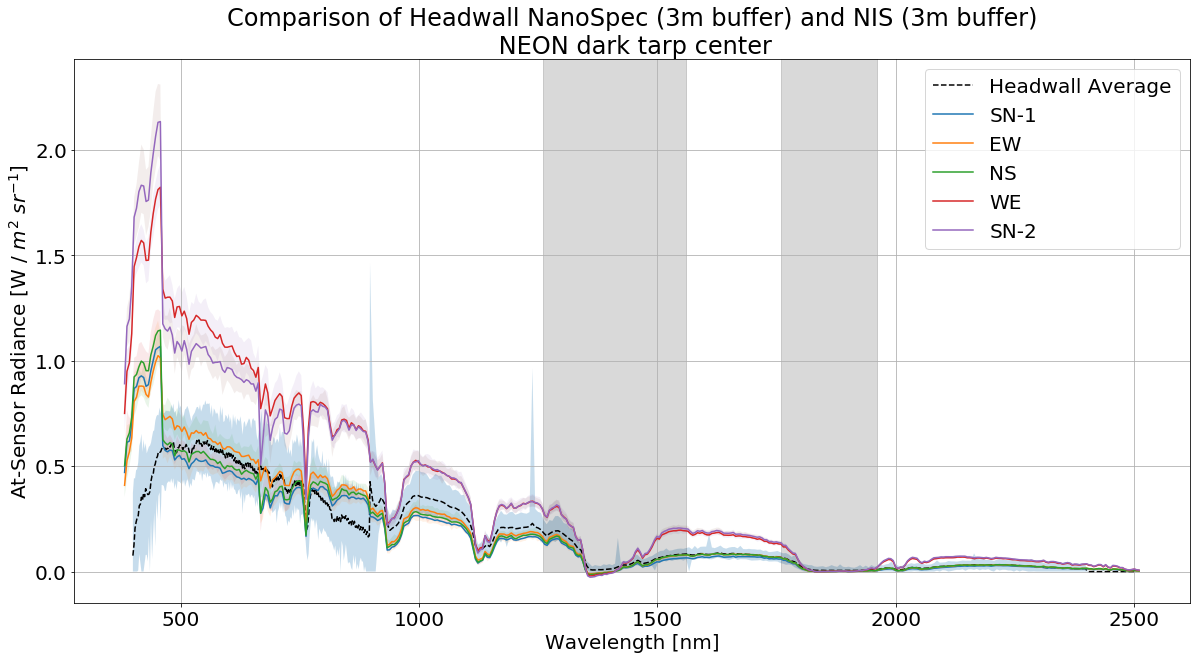

In [128]:
## do the extraction
hw_vnir_cube, hw_swir_cube, hw_arrs = extract_from_headwall_ENVI((xarr_VNIR, x_vnir, y_vnir), 
                                                                (xarr_SWIR, x_swir, y_swir), # they are flipped?!
                                                                pt_df_hw,
                                                                w_cutoff = 896) #896 is start of SWIR wavelength

full_wav, full_ex = hw_arrs

# neon flightlines
neon_wav_ls, full_neon_ls = [],[]
for xarr_NEON, x_neon, y_neon in zip(xarr_NEON_ls, x_neon_ls, y_neon_ls):
    neon_sub_cube, neon_arrs = extract_from_NEON((xarr_NEON, x_neon, y_neon), pt_df_neon)
    neon_wav, full_neon = neon_arrs
    
    neon_wav_ls.append(neon_wav)
    full_neon_ls.append(full_neon)
    
    
hw_mean = np.nanmean(full_ex, axis=1)
hw_max = np.nanmax(full_ex, axis=1)
hw_min = np.nanmin(full_ex, axis=1)

neon_mean_ls, neon_max_ls, neon_min_ls = [],[],[]
for full_neon in full_neon_ls:
    neon_mean = np.nanmean(full_neon, axis=1)
    neon_max = np.nanmax(full_neon, axis=1)
    neon_min = np.nanmin(full_neon, axis=1)
    
    neon_mean_ls.append(neon_mean)
    neon_max_ls.append(neon_max)
    neon_min_ls.append(neon_min)
    
font = {'family' : 'normal',
        'weight' : 'medium',
        'size'   : 20}

matplotlib.rc('font', **font)

plt.figure(figsize=(20,10))
# plt.plot(full_wav, hw_mean_ma, label='Headwall Average')
# plt.fill_between(full_wav, hw_min_ma, hw_max_ma, alpha=0.25)
plt.plot(full_wav, hw_mean, '--k', label='Headwall Average')
plt.fill_between(full_wav, hw_min, hw_max, alpha=0.25)

for neon_wav, neon_mean, neon_min, neon_max, fl in zip(neon_wav_ls, neon_mean_ls, neon_min_ls, neon_max_ls, fl_dir):
    plt.plot(neon_wav, neon_mean, label=fl)
    plt.fill_between(neon_wav, neon_min, neon_max, alpha=0.1)
    
# plt.plot(neon_wav, neon_mean_ma, label='NEON Average')
# plt.fill_between(neon_wav, neon_min_ma, neon_max_ma, alpha=0.25)

# 1260 to 1560 nm (Bands 98-128)
# 1760 to 1960 nm (Bands 148-170)
plt.gca().add_patch(
    plt.Rectangle((1260,0), 1560-1260, 20,color='k', alpha=0.15))

plt.gca().add_patch(
    plt.Rectangle((1760,0), 1960-1760, 20,color='k', alpha=0.15))

plt.title('Comparison of Headwall NanoSpec ({0}m buffer) and NIS ({0}m buffer)\n {1}'.format(buffer_dist, pt_label))
plt.xlabel('Wavelength [nm]')
plt.ylabel('At-Sensor Radiance [W / $m^2$ $sr^{-1}$]')
plt.grid(True)
plt.legend()
plt.show()

In [129]:
dark_tarp_mean, dark_tarp_std = bin_data(full_ex, full_wav, full_neon_ls, neon_wav, bin_res)

# do the same for road sample

In [130]:
## use the shapefile
pt_index = 4 # dark tarp
pt = gdf_4326['geometry'].values[pt_index]
pt_label = gdf_4326['comments'].values[pt_index]
pt_df = gpd.GeoDataFrame({'geometry' : [pt]}, crs=fiona.crs.from_epsg(4326))

# buffer them in the correct coordinate systems
pt_df_hw = pt_df.to_crs(epsg=3857).buffer(buffer_dist, resolution=1).to_crs(epsg=4326)
pt_df_neon = pt_df.to_crs(epsg=32613).buffer(buffer_dist)

In [131]:
# ## do the extraction
# neon_sub_cube, neon_arrs = extract_from_NEON((xarr_NEON, x_neon, y_neon), pt_df_neon)
# hw_vnir_cube, hw_swir_cube, hw_arrs = extract_from_headwall_ENVI((xarr_VNIR, x_vnir, y_vnir), 
#                                                             (xarr_SWIR, x_swir, y_swir),
#                                                             pt_df_hw)

# neon_wav, full_neon = neon_arrs
# full_wav, full_ex = hw_arrs

# hw_mean = np.nanmean(full_ex, axis=1)
# hw_max = np.nanmax(full_ex, axis=1)
# hw_min = np.nanmin(full_ex, axis=1)

# neon_mean = np.nanmean(full_neon, axis=1)
# neon_max = np.nanmax(full_neon, axis=1)
# neon_min = np.nanmin(full_neon, axis=1)

# ## replot masking bad bands:
# # 1260 to 1560 nm (Bands 98-128)
# # 1760 to 1960 nm (Bands 148-170)
# bad_neon = np.where(((neon_wav > 1260) & (neon_wav < 1560)) | ((neon_wav > 1760) & (neon_wav < 1960)))
# bad_hw = np.where(((full_wav > 1260) & (full_wav < 1560)) | ((full_wav > 1760) & (full_wav < 1960)))


# hw_mean_ma = hw_mean.copy()
# hw_mean_ma[bad_hw] = np.nan
# hw_max_ma = hw_max.copy()
# hw_max_ma[bad_hw] = np.nan
# hw_min_ma = hw_min.copy()
# hw_min_ma[bad_hw] = np.nan

# neon_mean_ma = neon_mean.copy()
# neon_mean_ma[bad_neon] = np.nan
# neon_max_ma = neon_max.copy()
# neon_max_ma[bad_neon] = np.nan
# neon_min_ma = neon_min.copy()
# neon_min_ma[bad_neon] = np.nan

In [132]:
# asd_spectra1 = "../CUASD/20190409_TBMT_P3C1/EWRoad1/EWRoad1_refl.spectra"
# asd_spectra2 = "../CUASD/20190409_TBMT_P3C1/EWRoad2/EWRoad2_refl.spectra"
# asd1 = pd.read_csv(asd_spectra1, names=['wavelength', 'refl'], header=None, delimiter=r'\t', engine='python')
# asd2 = pd.read_csv(asd_spectra2, names=['wavelength', 'refl'], header=None, delimiter=r'\t', engine='python')

# ## mask the water vapor features
# asd_wav = asd1.wavelength.values
# asd_refl = asd1.refl.values
# bad_asd = np.where(((asd_wav > 1260) & (asd_wav < 1560)) | ((asd_wav > 1760) & (asd_wav < 1960)))
# asd_refl[bad_asd] = np.nan

In [133]:
# plt.figure(figsize=(20,10))
# plt.plot(full_wav, hw_mean_ma, label='Headwall Average')
# plt.fill_between(full_wav, hw_min_ma, hw_max_ma, alpha=0.25)
# plt.plot(neon_wav, neon_mean_ma, label='NEON (ELM) Average')
# plt.fill_between(neon_wav, neon_min_ma, neon_max_ma, alpha=0.25)

# # ASD spectra
# #plt.plot(asd_wav, asd_refl, linewidth=6, alpha=0.5, label='ASD Spectra')

# plt.title('Comparison of Headwall NanoSpec ({0}m buffer) and NIS ({0}m buffer)\n \
#           {1} strip {2}'.format(buffer_dist, fl_dir, pt_label))
# plt.xlabel('Wavelength [nm]')
# plt.ylabel('At-Sensor Radiance [W / $m^2$ $sr^{-1}$]')
# plt.grid(True)
# plt.legend()
# plt.ylim(top=5.2)
# plt.show()

(40, 52, 270) (41, 53, 270)


D:\projects\headwall_neon\notebooks\xarr_helpers.py:245: UserWarning: extracted shapes are not equal, shaving some off...
  warnings.warn('extracted shapes are not equal, shaving some off...')


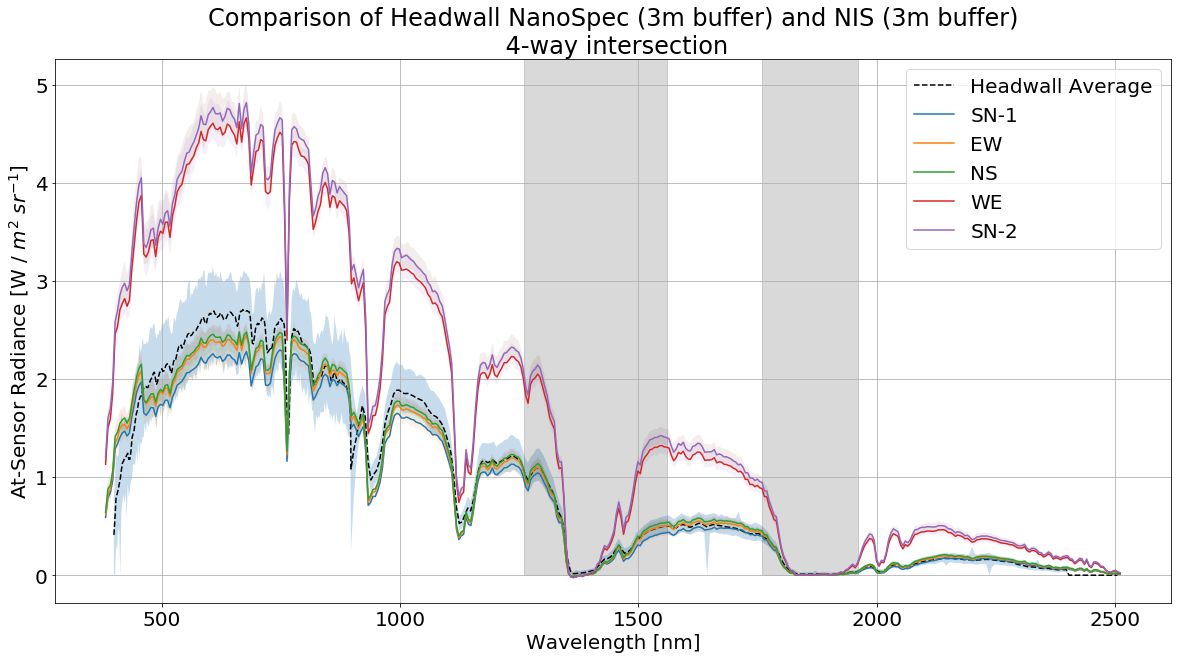

In [134]:
## do the extraction
hw_vnir_cube, hw_swir_cube, hw_arrs = extract_from_headwall_ENVI((xarr_VNIR, x_vnir, y_vnir), 
                                                                (xarr_SWIR, x_swir, y_swir), # they are flipped?!
                                                                pt_df_hw,
                                                                w_cutoff = 896) #896 is start of SWIR wavelength

full_wav, full_ex = hw_arrs

# neon flightlines
neon_wav_ls, full_neon_ls = [],[]
for xarr_NEON, x_neon, y_neon in zip(xarr_NEON_ls, x_neon_ls, y_neon_ls):
    neon_sub_cube, neon_arrs = extract_from_NEON((xarr_NEON, x_neon, y_neon), pt_df_neon)
    neon_wav, full_neon = neon_arrs
    
    neon_wav_ls.append(neon_wav)
    full_neon_ls.append(full_neon)
    
    
hw_mean = np.nanmean(full_ex, axis=1)
hw_max = np.nanmax(full_ex, axis=1)
hw_min = np.nanmin(full_ex, axis=1)

neon_mean_ls, neon_max_ls, neon_min_ls = [],[],[]
for full_neon in full_neon_ls:
    neon_mean = np.nanmean(full_neon, axis=1)
    neon_max = np.nanmax(full_neon, axis=1)
    neon_min = np.nanmin(full_neon, axis=1)
    
    neon_mean_ls.append(neon_mean)
    neon_max_ls.append(neon_max)
    neon_min_ls.append(neon_min)
    
font = {'family' : 'normal',
        'weight' : 'medium',
        'size'   : 20}

matplotlib.rc('font', **font)

plt.figure(figsize=(20,10))
# plt.plot(full_wav, hw_mean_ma, label='Headwall Average')
# plt.fill_between(full_wav, hw_min_ma, hw_max_ma, alpha=0.25)
plt.plot(full_wav, hw_mean, '--k', label='Headwall Average')
plt.fill_between(full_wav, hw_min, hw_max, alpha=0.25)

for neon_wav, neon_mean, neon_min, neon_max, fl in zip(neon_wav_ls, neon_mean_ls, neon_min_ls, neon_max_ls, fl_dir):
    plt.plot(neon_wav, neon_mean, label=fl)
    plt.fill_between(neon_wav, neon_min, neon_max, alpha=0.1)
    
# plt.plot(neon_wav, neon_mean_ma, label='NEON Average')
# plt.fill_between(neon_wav, neon_min_ma, neon_max_ma, alpha=0.25)

# 1260 to 1560 nm (Bands 98-128)
# 1760 to 1960 nm (Bands 148-170)
plt.gca().add_patch(
    plt.Rectangle((1260,0), 1560-1260, 20,color='k', alpha=0.15))

plt.gca().add_patch(
    plt.Rectangle((1760,0), 1960-1760, 20,color='k', alpha=0.15))

plt.title('Comparison of Headwall NanoSpec ({0}m buffer) and NIS ({0}m buffer)\n {1}'.format(buffer_dist, pt_label))
plt.xlabel('Wavelength [nm]')
plt.ylabel('At-Sensor Radiance [W / $m^2$ $sr^{-1}$]')
plt.grid(True)
plt.legend()
plt.show()

# summarize in 200nm bins

In [135]:
#res = 200
res = bin_res
neon_std_ls, hw_std_ls = [],[]
neon_mean_ls, hw_mean_ls = [],[]
band_ranges = []
for bc in np.arange(full_wav[0]+res/2, full_wav[-1], res):
    w_min = bc - res/2
    w_max = bc + res/2
    band_ranges.append((w_min, bc, w_max))
    #print(w_min,bc, w_max)
    
    # get min bands for headwall
    h_b_min = np.where(full_wav >= w_min)[0][0] + 1 # +1 due to 1 based indexing on band
    h_b_max = np.where(full_wav <= w_max)[0][-1] + 1 # +1 due to 1 based indexing on band
    
    # record std and mean
    hw_std = np.nanstd(full_ex[h_b_min:h_b_max,:])
    hw_std_ls.append(hw_std)
    hw_mean = np.nanmean(full_ex[h_b_min:h_b_max,:])
    hw_mean_ls.append(hw_mean)
    
    # get min bands for NEON
    n_b_min = np.where(neon_wav >= w_min)[0][0] + 1 # +1 due to 1 based indexing on band
    n_b_max = np.where(neon_wav <= w_max)[0][-1] + 1 # +1 due to 1 based indexing on band
    
    # record std for each NEON group
    temp_, temp__ = [],[]
    for full_neon in full_neon_ls:
        neon_std = np.nanstd(full_neon[n_b_min:n_b_max,:])
        temp_.append(neon_std)
        
        neon_mean = np.nanmean(full_neon[n_b_min:n_b_max,:])
        temp__.append(neon_mean)
        
    neon_std_ls.append(temp_)
    neon_mean_ls.append(temp__)

    

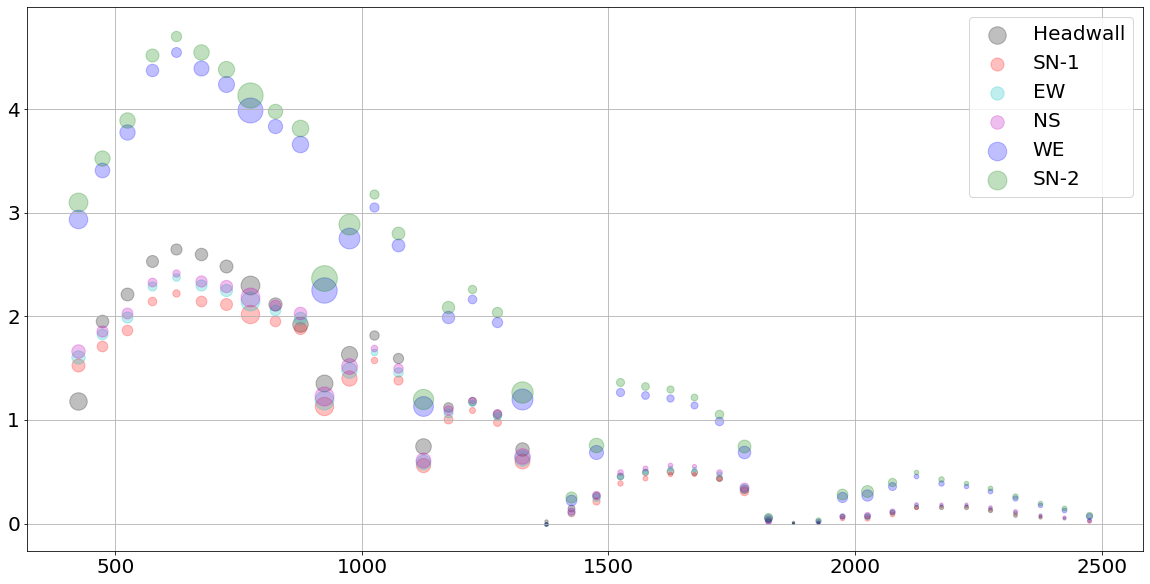

In [136]:
plt.figure(figsize=(20,10))
colors=['k','r', 'c', 'm', 'b', 'g']
for i in range(len(hw_std_ls)):
    
    plt.scatter(band_ranges[i][1], hw_mean_ls[i], color=colors[0], s=hw_std_ls[i]*1000, alpha=0.25, label='Headwall')
    
    for j in range(len(neon_mean_ls[i])):
        #print(neon_mean_ls[i][j])
        plt.scatter(band_ranges[i][1], neon_mean_ls[i][j], color=colors[j+1], s=neon_std_ls[i][j]*1000, alpha=0.25, label=fl_dir[j])

    if i==0:
        plt.legend()
        
plt.grid(True)        
plt.show()

In [137]:
band_ranges[0]

(399.065, 424.065, 449.065)

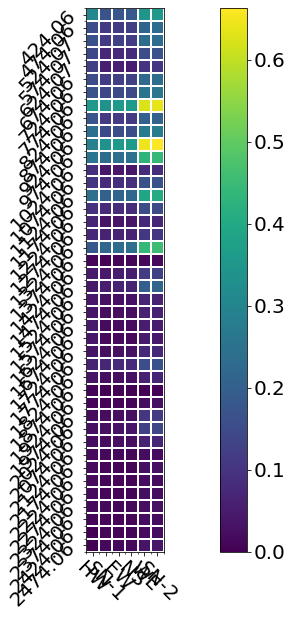

In [138]:
arr_std = np.hstack((np.expand_dims(np.array(hw_std_ls),axis=1), np.array(neon_std_ls)))

fig, ax1 = plt.subplots(figsize=(20,10))
a = ax1.imshow(arr_std, alpha=1.0)
ax1.set_xticks(np.arange(0, arr_std.shape[1], 1));
ax1.set_yticks(np.arange(0, arr_std.shape[0], 1));

# Minor ticks
ax1.set_xticks(np.arange(-.5, arr_std.shape[1], 1), minor=True);
ax1.set_yticks(np.arange(-.5, arr_std.shape[0], 1), minor=True);

# Gridlines based on minor ticks
ax1.grid(which='minor', color='w', linestyle='-', linewidth=2)

ax1.set_yticklabels([round(b[1],2) for b in band_ranges], rotation=45)
ax1.set_xticklabels(['HW'] + fl_dir, rotation=-45)
plt.colorbar(a)
plt.show()


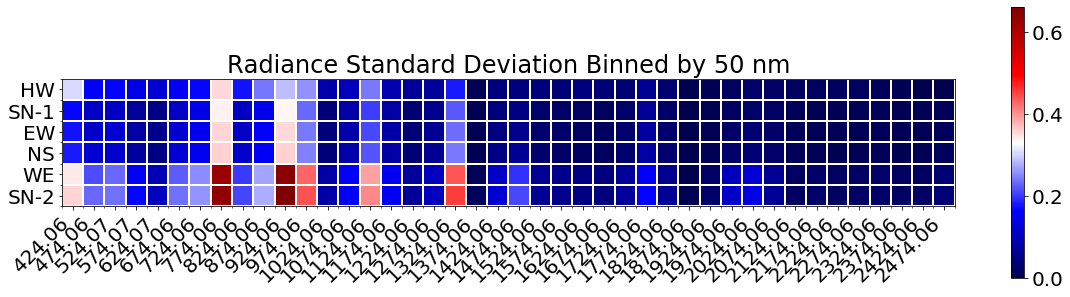

In [139]:
fig, ax1 = plt.subplots(figsize=(20,5))
a = ax1.imshow(arr_std.T, alpha=1.0, cmap='seismic')
ax1.set_yticks(np.arange(0, arr_std.shape[1], 1));
ax1.set_xticks(np.arange(0, arr_std.shape[0], 1));

# Minor ticks
ax1.set_yticks(np.arange(-.5, arr_std.shape[1], 1), minor=True);
ax1.set_xticks(np.arange(-.5, arr_std.shape[0], 1), minor=True);

# Gridlines based on minor ticks
ax1.grid(which='minor', color='w', linestyle='-', linewidth=2)

ax1.set_xticklabels([round(b[1],2) for b in band_ranges], rotation=45, ha='right')
ax1.set_yticklabels(['HW'] + fl_dir, rotation=0)
plt.colorbar(a)
plt.title('Radiance Standard Deviation Binned by {} nm'.format(res))
plt.show()

C:\software\anaconda3\envs\geo_py\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


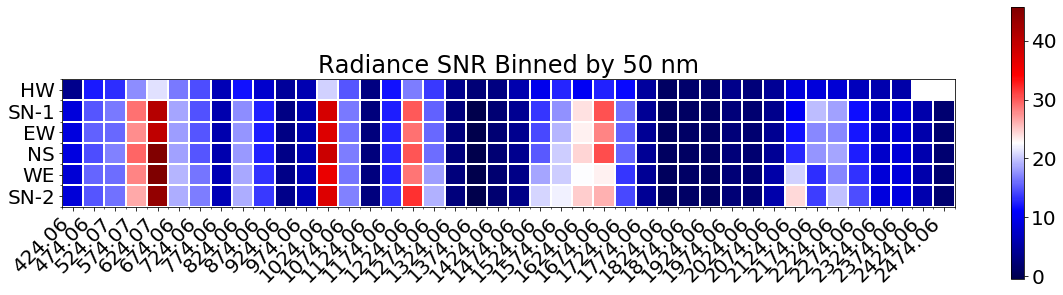

In [140]:
arr_std = np.hstack((np.expand_dims(np.array(hw_std_ls),axis=1), np.array(neon_std_ls)))
arr_mean = np.hstack((np.expand_dims(np.array(hw_mean_ls),axis=1), np.array(neon_mean_ls)))
arr_snr = arr_mean / arr_std

fig, ax1 = plt.subplots(figsize=(20,5))
a = ax1.imshow(arr_snr.T, alpha=1.0, cmap='seismic')
ax1.set_yticks(np.arange(0, arr_std.shape[1], 1));
ax1.set_xticks(np.arange(0, arr_std.shape[0], 1));

# Minor ticks
ax1.set_yticks(np.arange(-.5, arr_std.shape[1], 1), minor=True);
ax1.set_xticks(np.arange(-.5, arr_std.shape[0], 1), minor=True);

# Gridlines based on minor ticks
ax1.grid(which='minor', color='w', linestyle='-', linewidth=2)

ax1.set_xticklabels([round(b[1],2) for b in band_ranges], rotation=45, ha='right')
ax1.set_yticklabels(['HW'] + fl_dir, rotation=0)
plt.colorbar(a)
plt.title('Radiance SNR Binned by {} nm'.format(res))
plt.show()

C:\software\anaconda3\envs\geo_py\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


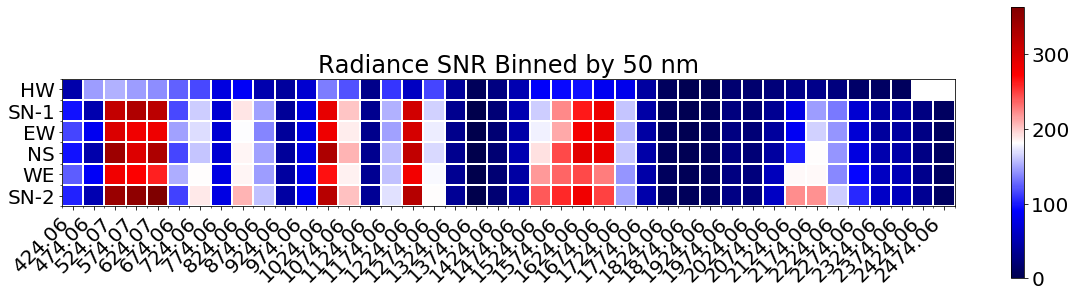

In [141]:
arr_snr = light_tarp_mean / dark_tarp_std

fig, ax1 = plt.subplots(figsize=(20,5))
a = ax1.imshow(arr_snr.T, alpha=1.0, cmap='seismic')
ax1.set_yticks(np.arange(0, arr_std.shape[1], 1));
ax1.set_xticks(np.arange(0, arr_std.shape[0], 1));

# Minor ticks
ax1.set_yticks(np.arange(-.5, arr_std.shape[1], 1), minor=True);
ax1.set_xticks(np.arange(-.5, arr_std.shape[0], 1), minor=True);

# Gridlines based on minor ticks
ax1.grid(which='minor', color='w', linestyle='-', linewidth=2)

ax1.set_xticklabels([round(b[1],2) for b in band_ranges], rotation=45, ha='right')
ax1.set_yticklabels(['HW'] + fl_dir, rotation=0)
plt.colorbar(a)
plt.title('Radiance SNR Binned by {} nm'.format(res))
plt.show()